In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings

from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
#from tensor_forest.python import tensor_forest
#from tensorflow.python.ops import resources




COLAB = ('COLAB_GPU' in os.environ)  # True if we are in a Colab environment

# Origin of Zip file
FILENAME1 = 'weather_features.csv'
FILENAME2 = 'energy_dataset.csv'

if COLAB:
    DIRNAME = '/content/drive/My Drive/Colab Notebooks/ENERGY/DATA/'
else:
    DIRNAME = './'

if COLAB:
    # Mount drive
    from google.colab import drive
    import shutil
    
    drive.mount("/content/drive")
    shutil.copy(DIRNAME+FILENAME1, FILENAME1)
    shutil.copy(DIRNAME+FILENAME2, FILENAME2)

print('Ready!!')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


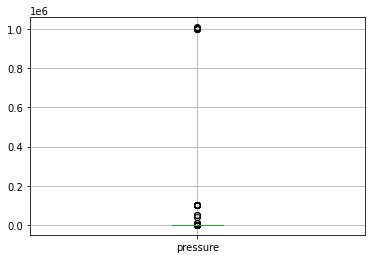

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


In [ ]:
## WEATHER
#leemos el dataset del Tiempo y indicamos que son fechas la columna 'dt_iso'
df_weather = pd.read_csv(FILENAME1, parse_dates=['dt_iso'])

#Elimina columnas innecesarias sobre el dataset (no crea copia)
df_weather.drop(['weather_main', 'weather_id', 'weather_description', 
                 'weather_icon', 'rain_3h'], axis=1, inplace = True)

#Elimina filas con la misma fecha y ciudad (se queda con la primera)
df_weather.drop_duplicates(subset=['dt_iso', 'city_name'], keep='first',
                           inplace = True)

#Definimos un Indice para nuestro dataset a la vez que hacemos Cast para que sean fechas.
df_weather.set_index(pd.to_datetime(df_weather['dt_iso'], utc=True, 
                                    infer_datetime_format=True), 
                     inplace=True, drop=True)

#Elimina la columna de la fecha porque ya la ha hecho indice
df_weather.drop(['dt_iso'], axis=1, inplace = True)


#Define el nombre del indice como "time"
df_weather.index.name = 'time'

#Selecciona las columnas, creo que pasa los numeros de int a float...
cols = df_weather.select_dtypes(include=[np.int64]).columns

for col in cols:
    df_weather[col] = df_weather[col].values.astype(np.float64)

#Boxplot de pressure
boxplot = df_weather.boxplot(column = ['pressure'])
boxplot.plot()

plt.show()

#Outliers
df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan
df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

#Se eliminan esas porque en la historia nunca se han registrado
#temperaturas superiores/inferiores

#Rellena los NaN vía interpolación
df_weather.interpolate(method='linear', limit_direction='forward', 
                       inplace=True, axis=0)

# ENERGY
##Leemos el dataset de Consumo e indicamos que son fechas la columna 'time'.
df_energy = pd.read_csv(FILENAME2, parse_dates=['time'])
#Definimos el indice como la columna 'Time'
df_energy.set_index(pd.to_datetime(df_energy['time'], utc=True, 
                                    infer_datetime_format=True), 
                     inplace=True, drop=True)
#Definimos el nombre del indice (igual que el de la columna)
df_energy.index.name = 'time'
#Eliminamos todas las columnas que no son de utilidad + la que hemos hecho indice.
df_energy.drop(['time', 'generation fossil coal-derived gas',
                'generation fossil oil shale', 'generation fossil peat',
                'generation geothermal',
                'generation hydro pumped storage aggregated', 
                'generation marine', 'generation wind offshore', 
                'forecast wind offshore eday ahead', 'total load forecast', 
                'forecast solar day ahead', 'forecast wind onshore day ahead'], 
               axis=1, inplace = True)

#Rellenamos los NaN por medio de la interpolación
df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, 
                      axis=0)

# Dividimos el dataset del tiempo en 5, uno por cada ciudad ##PREGUNTAR SINTAXIS
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

# Final Merge #Conexion = Merge, unir Dataframes
df_final = df_energy
for df in dfs:
    ##Preguntar estas 3 lineas:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)

df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

# LIMPIAMOS EL ENTORNO
del FILENAME1, FILENAME2, DIRNAME
del dfs, df_1, df_2, df_3, df_4, df_5, city, city_str, col, cols
del df_weather, df_energy

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))
print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(df_final.duplicated(keep='first').sum()))

In [ ]:
## Generación de caracteristicas
##Genera 3 columnas: hora, semana & mes
df_final['hour'] = df_final.index.hour
df_final['weekday'] = df_final.index.weekday
df_final['month'] = df_final.index.month

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

    weekday = df_final['weekday'].iloc[i]    
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

# Temperature 
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final['temp_range_{}'.format(city)] = abs(
        df_final['temp_max_{}'.format(city)] - 
        df_final['temp_min_{}'.format(city)]
    )

# Calculamos el peso de cada ciudad
total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000
weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop
cities_weights = {'Madrid': weight_Madrid, 
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}
                  
#Creamos un array de 0s con la longitud del data set                  
temp_weighted = [0]*len(df_final)

for city in cities:
    temp_weighted += df_final['temp_{}'.format(city)] * cities_weights.get('{}'.format(city))
df_final['temp_weighted'] = temp_weighted

df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

del cities, city, total_pop, weight_Madrid, weight_Barcelona
del weight_Seville, weight_Bilbao, cities_weights, temp_weighted

In [ ]:

# Definimos la funcion datos_multivariables
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

train_end_idx = 27048 #indice hasta donde llegan los datos de entrenamiento
cv_end_idx = 31056  #indice hasta donde llegan los datos de validación
test_end_idx = 35064 #indice hasta donde llegan los datos de test

y = df_final['price actual'].values #Datos Target
y = y.reshape(-1, 1) #En columna
X = df_final[df_final.columns.drop('price actual')].values  #En X el datset sin la columna de precios

scaler_X = MinMaxScaler(feature_range=(0, 1)) #Creamos un escalador para las X
scaler_y = MinMaxScaler(feature_range=(0, 1)) #creamos un escalador para las Y

scaler_X.fit(X[:train_end_idx]) #Ajustamos escalador para las X
scaler_y.fit(y[:train_end_idx]) #Ajustamos el otro escalador para las Y (debe ser distinto)

X_norm = scaler_X.transform(X) #Escalamos las X
y_norm = scaler_y.transform(y) #Escalamos las Y

#Analisis de los Componenetes principales (eliminamos los que tienen una correlacion superior a 85%)
#Mejora levemente la predicción
pca = PCA(n_components=0.85) #Creamos el PCA
pca.fit(X_norm[:train_end_idx]) #Ajustamos el PCA para los datos de entrenamiento

X_pca = pca.transform(X_norm) 

past_history = 7 #Cada chunk de 24
future_target = 0 #El target justo en el que toca

dataset_norm = np.concatenate((X_pca, y_norm), axis=1) 
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)
#X_train, y_train = multivariate_data(X_pca, y_norm[:, -1],
#                                     0, train_end_idx, past_history, 
#                                     future_target, step=1, single_step=True)
#X_val, y_val = multivariate_data(X_pca, y_norm[:, -1],
#                                 train_end_idx, cv_end_idx, past_history, 
#                                 future_target, step=1, single_step=True)
#X_test, y_test = multivariate_data(X_pca, y_norm[:, -1],
#                                   cv_end_idx, test_end_idx, past_history, 
#                                   future_target, step=1, single_step=True)

batch_size = 32
buffer_size = 1000

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

# Definimos parametros comunes para todos los Modelos que utilizaremos
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError() #Objeto para error
metric = [tf.keras.metrics.RootMeanSquaredError()] #metrica que utilizaremos para que cuadre con nuestro error
#Programamos la tasa de aprendizaje
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
#para que pare si deja de aprender en 10 iteracciones
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
#Datos de test en columna
y_test = y_test.reshape(-1, 1)

#DAtos de test a la inversa
y_test_inv = scaler_y.inverse_transform(y_test) ##MIrar qué transformación

Funcion para representar gráficamente RMSE y Predicción

In [ ]:
#Funcion que representa gráficamente

def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    
    #Visualizamos ciclos VS perdidas y aciertos en Entrenamiento y Validación
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()
    #Fin función de pintar RMSE

def show_prediction(plot_data,delta,title):

    labels = ["Historial", "Verdadero Futuro", "Predicción Modelo"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]),0))

    if delta:
        future = delta
    else:
         future = 0
    
    plt.title(title)
    
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return



LSTM

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
846/846 [==============================] - 5s 4ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0516
Epoch 2/120
846/846 [==============================] - 3s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 3/120
846/846 [==============================] - 3s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0324
Epoch 4/120
846/846 [==============================] - 3s 3ms/step - loss: 9.5218e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 5/120
846/846 [==============================] - 3s 4ms/step - loss: 8.9118e-04 - root_mean_squared_error: 0.0299 - val_loss: 9.0412e-04 - val_root_mean_squared_error: 0.0301
Epoch 6/120
846/846 [==============================] - 3s 3ms/step - loss: 7.6972e-04 - root_mean_squared_error: 0.0277 - v

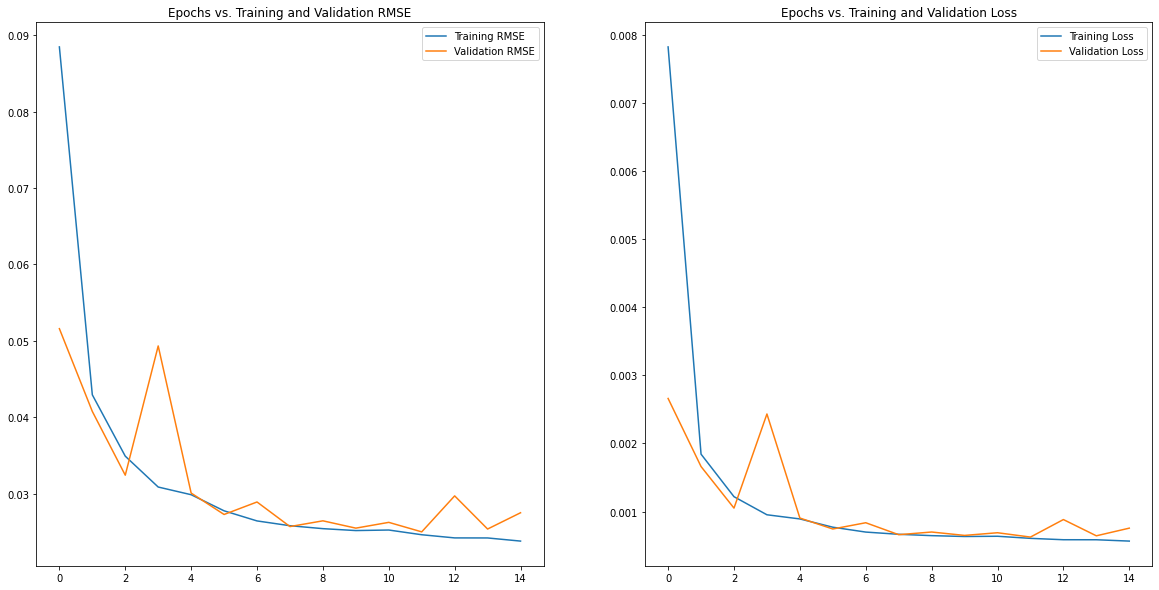

RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante de LSTM: 2.88
Vamos a hacer predicciones para 5 conjuntos de valores del conjunto de validación:


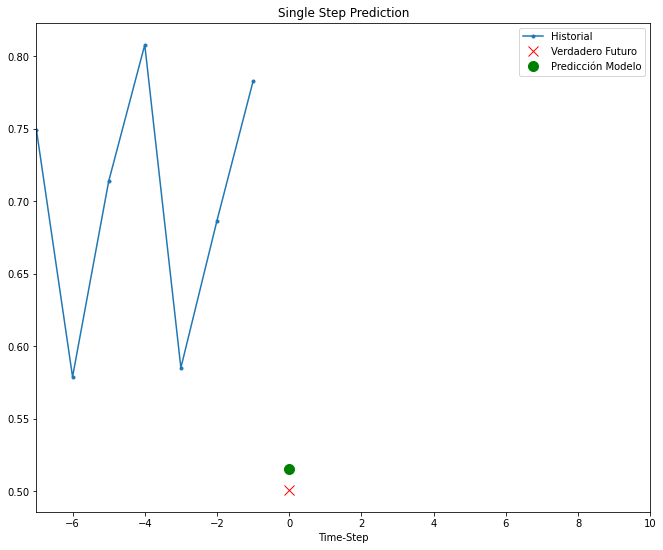

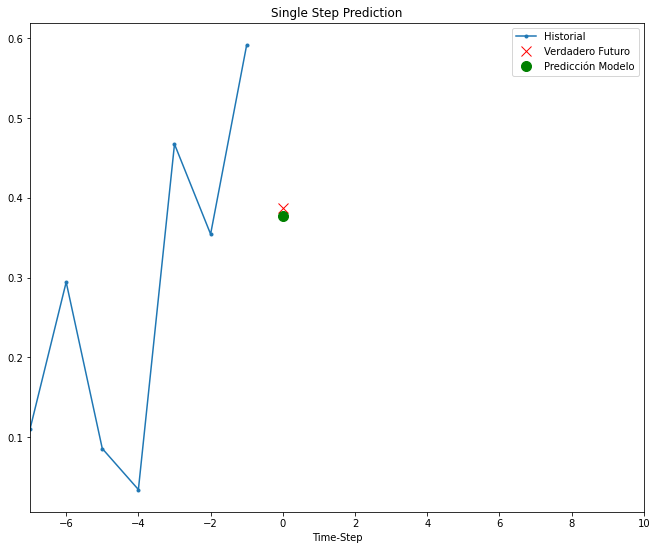

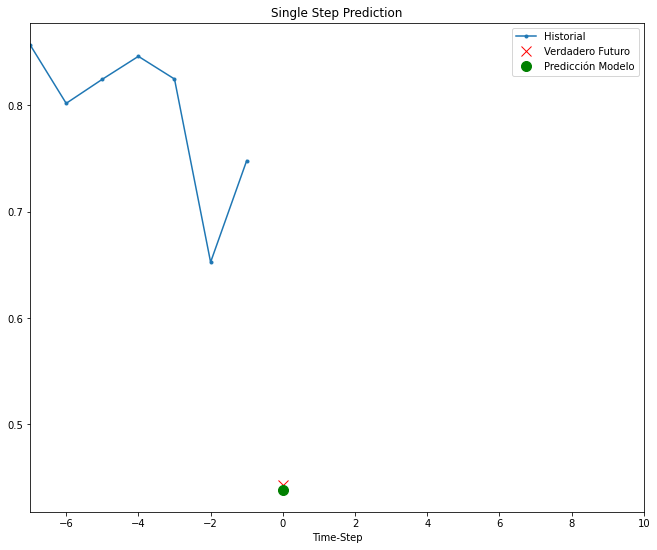

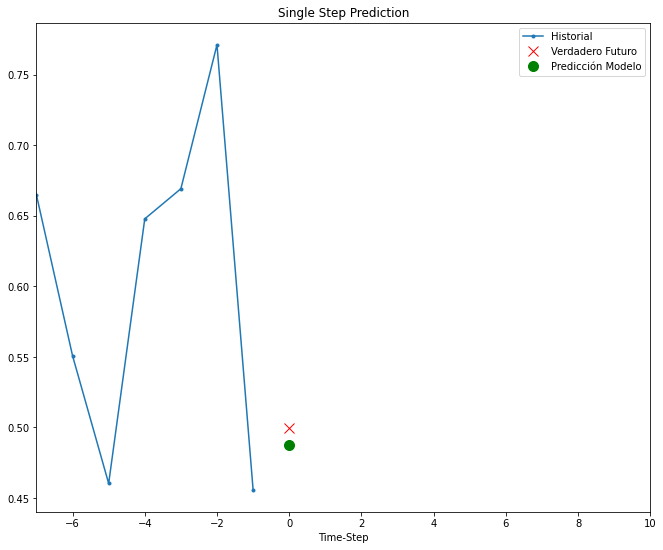

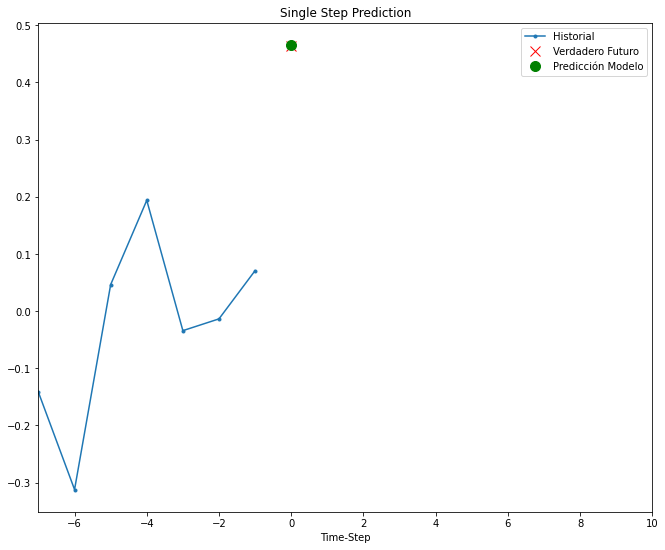

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            48400     
_________________________________________________________________
flatten (Flatten)            (None, 700)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               140200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 188,801
Trainable params: 188,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:

##Creamos el modelos secuecial LSTM
multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

#Vamos a ir guardando en el archivo .h5 el mejor modelo (con los mejores pesos)
#Guardamos solo el MEJOR modelo ('save_best_only')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('multivariate_lstm.h5',
                                                      monitor=('val_loss'), 
                                                      save_best_only=True)

#Determinamos el optimizador que vamos utilizar
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

#Especificamos la configuración del entrenamiento:
#¿Qué optimizador utiizamos para entrenamiento?
#¿Qué metrica utilizamos para monitorizar?
#¿Qué pérdidas calculamos?
multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

#Entrenamos el modelo con fit() y nos quedamos con el objeto history
#El objeto history, contien los valores de pérdida y métricos de entrenamientos
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])
plot_model_rmse_and_loss(history)


#Restauramos siempre el mejor modelo obtenido que estaba aqui guardado
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

#Generamos las predicciones
forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante de LSTM: {}'
      .format(round(rmse_lstm, 3)))

print('Vamos a hacer predicciones para 5 conjuntos de valores del conjunto de validación:')

for x, y in validation.take(5):
    show_prediction(
        [x[0][:, 1].numpy(), y[0].numpy(), multivariate_lstm.predict(x)[0]],
        0,
        "Single Step Prediction",
    )

multivariate_lstm.summary()

VAINILLA LSTM (muy simple)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
846/846 [==============================] - 4s 4ms/step - loss: 0.0075 - root_mean_squared_error: 0.0816 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0605
Epoch 2/120
846/846 [==============================] - 3s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 3/120
846/846 [==============================] - 3s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 4/120
846/846 [==============================] - 3s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 5/120
846/846 [==============================] - 3s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336 - val_loss: 8.0887e-04 - val_root_mean_squared_error: 0.0284
Epoch 6/120
846/846 [==============================] - 3s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 7.9

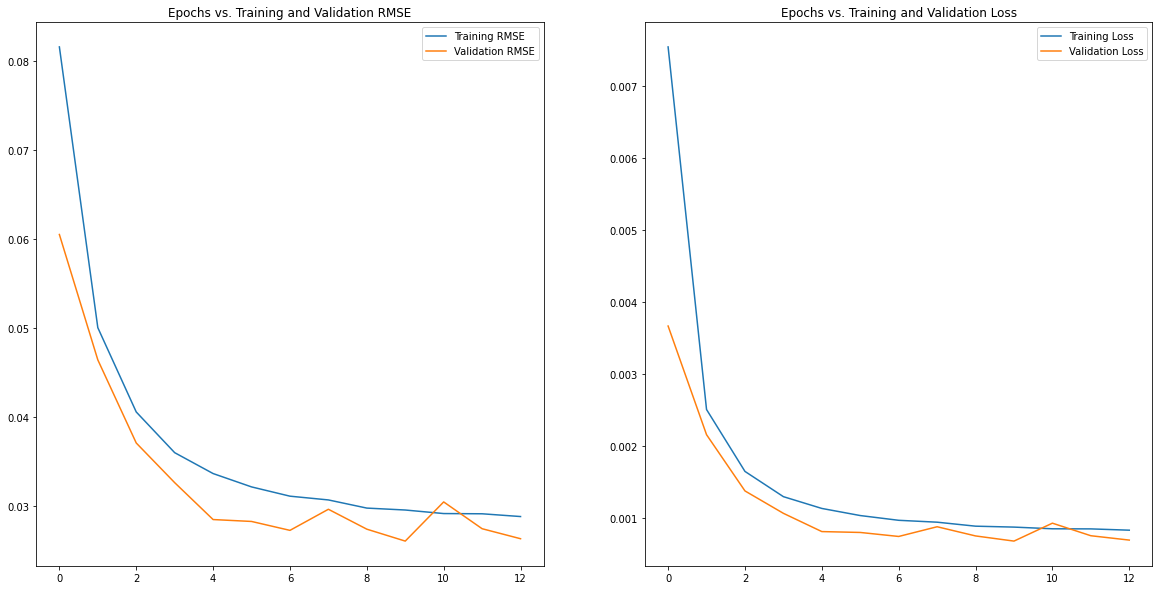

RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante de Vainilla-LSTM: 2.418
Vamos a hacer predicciones para 5 conjuntos de valores del conjunto de validación:


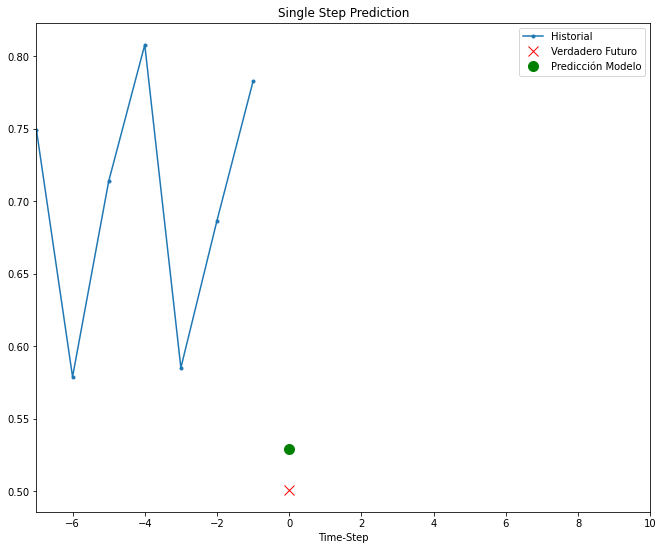

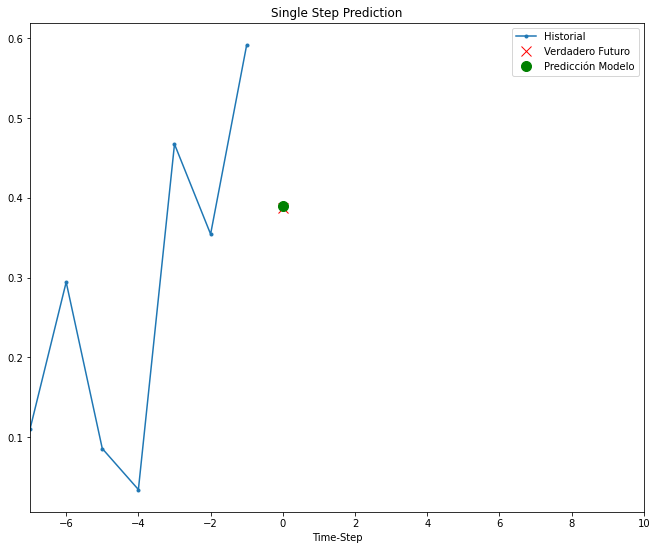

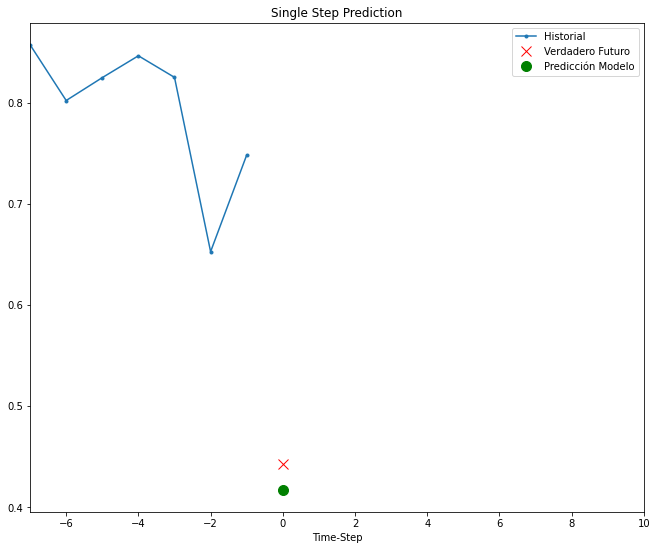

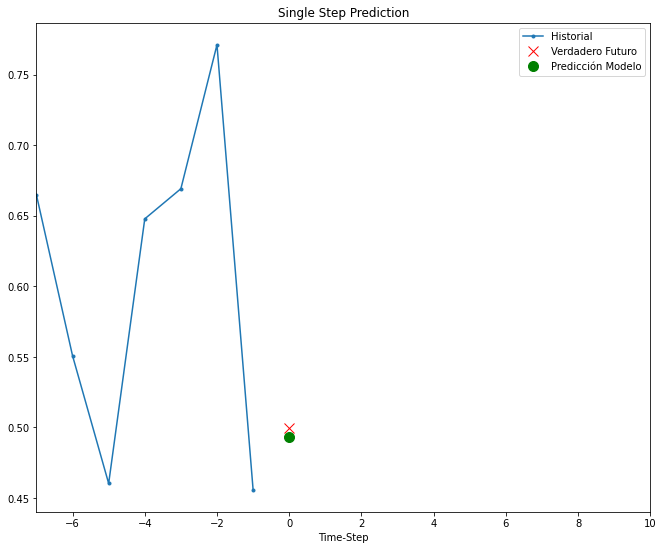

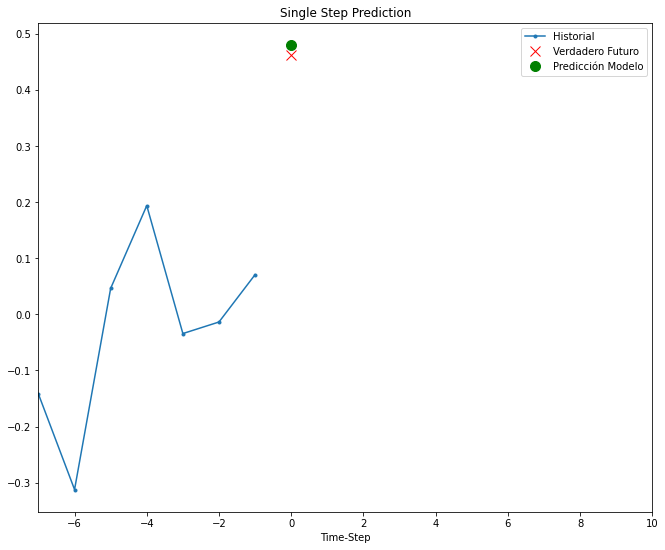

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 50)             14200     
_________________________________________________________________
flatten (Flatten)            (None, 350)               0         
_________________________________________________________________
dropout (Dropout)            (None, 350)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 351       
Total params: 14,551
Trainable params: 14,551
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Limpiamos el anterior
tf.keras.backend.clear_session()

#Definimos el modelo
multivariate_vainilla_lstm =tf.keras.models.Sequential([
#    LSTM(50, activation='relu', input_shape=input_shape,
#         return_sequences = True),
    LSTM(50, input_shape=input_shape, return_sequences = True),
    Flatten(), #Aplana, dimensiona
    Dropout(0.4), #Reduce el aprendizaje
    Dense(1)                                                                      
])

#Creamos el fichero de checkpoints y lo configuramos que solo guarde el mejor
model_checkpoint =tf.keras.callbacks.ModelCheckpoint(
    'multivariate_vainilla_lstm.h5', save_best_only = True)

optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

#Compilamos el modelo
multivariate_vainilla_lstm.compile(loss = loss,
                                   optimizer = optimizer,
                                   metrics = metric)

##Segun stackOverflow, se soluciona asi:
#nsamples, nx, ny = train.shape
#d2_train_dataset = train.reshape((nsamples,nx*ny))

#Entrenamos nuestro modelo LSTM Vainilla
history = multivariate_vainilla_lstm.fit(train, epochs=120,
                                         validation_data=validation,
                                         callbacks = [early_stopping,
                                                      model_checkpoint])

#Lo pintamos
plot_model_rmse_and_loss(history)

#Callback por si ha mejorado
multivariate_vainilla_lstm = tf.keras.models.load_model('multivariate_vainilla_lstm.h5')

#Predicción
forecast = multivariate_vainilla_lstm.predict(X_test)
multivariate_vainilla_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_vainilla_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_vainilla_lstm_forecast))
print('RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante de Vainilla-LSTM: {}'
      .format(round(rmse_mult_vainilla_lstm, 3)))

print('Vamos a hacer predicciones para 5 conjuntos de valores del conjunto de validación:')

for x, y in validation.take(5):
    show_prediction(
        [x[0][:, 1].numpy(), y[0].numpy(), multivariate_vainilla_lstm.predict(x)[0]],
        0,
        "Single Step Prediction",
    )

#Resumen del modelo 
multivariate_vainilla_lstm.summary()


Stacked LSTM V2

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
846/846 [==============================] - 7s 5ms/step - loss: 0.0046 - root_mean_squared_error: 0.0639 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 2/120
846/846 [==============================] - 4s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0517
Epoch 3/120
846/846 [==============================] - 4s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 9.1942e-04 - val_root_mean_squared_error: 0.0303
Epoch 4/120
846/846 [==============================] - 4s 5ms/step - loss: 8.1543e-04 - root_mean_squared_error: 0.0286 - val_loss: 7.1108e-04 - val_root_mean_squared_error: 0.0267
Epoch 5/120
846/846 [==============================] - 4s 5ms/step - loss: 7.6430e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 6/120
846/846 [==============================] - 4s 5ms/step - loss: 7.7000e-04 - root_mean_squared_error: 0.0277

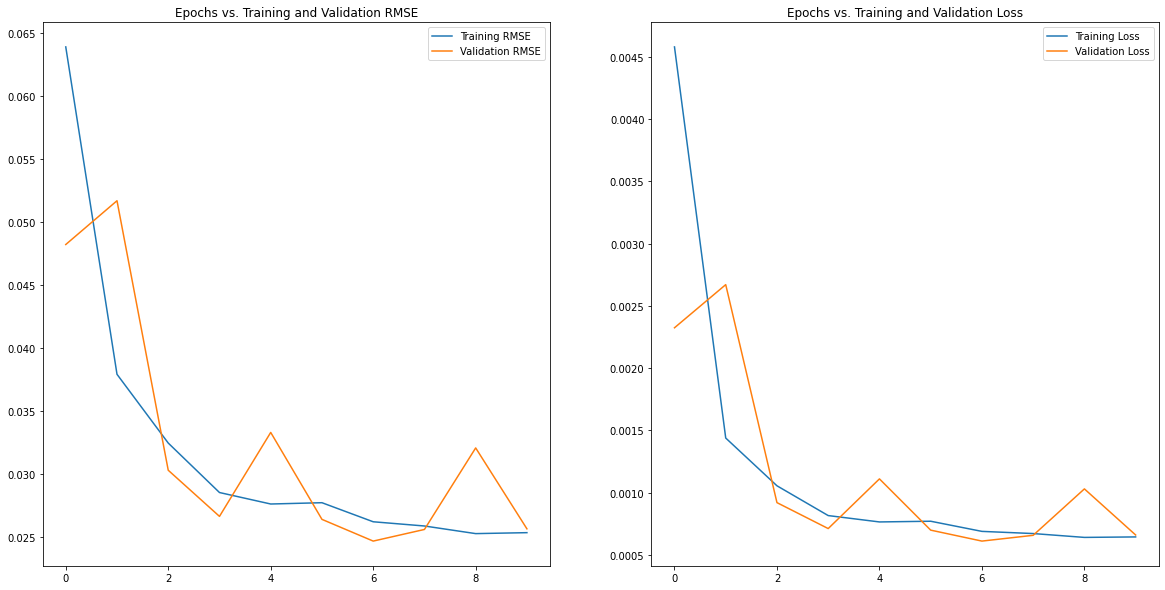

RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante de LSTM apilado: 2.344
Vamos a hacer predicciones para 5 conjuntos de valores del conjunto de validación:


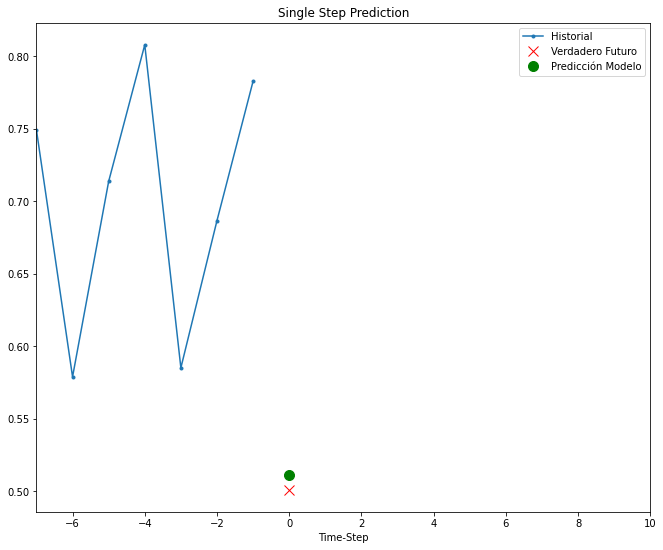

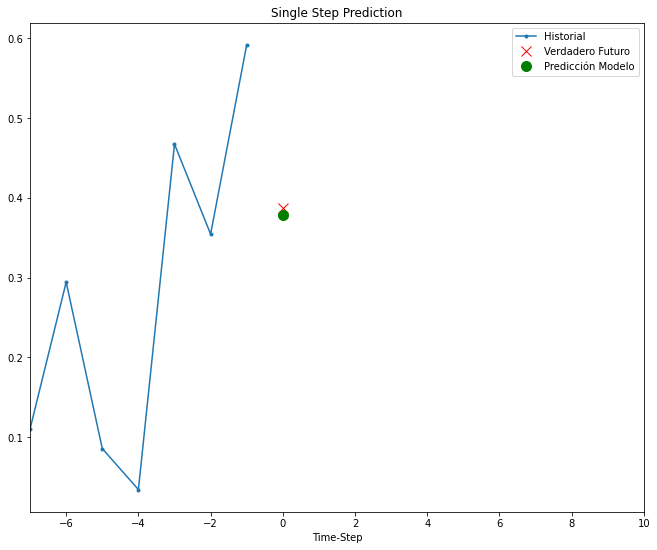

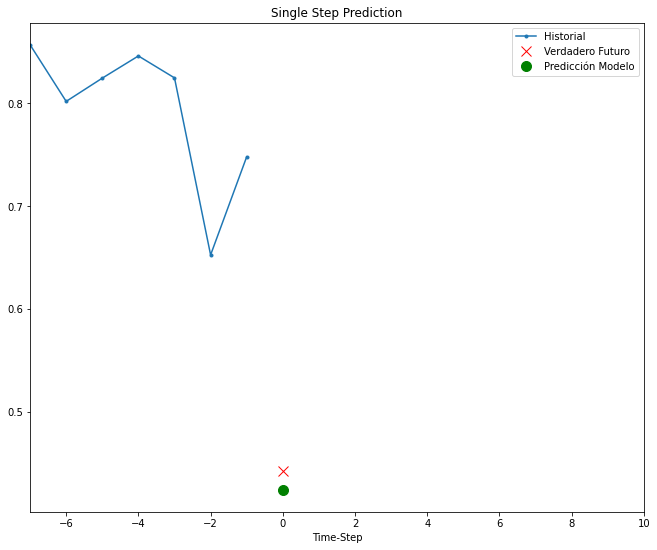

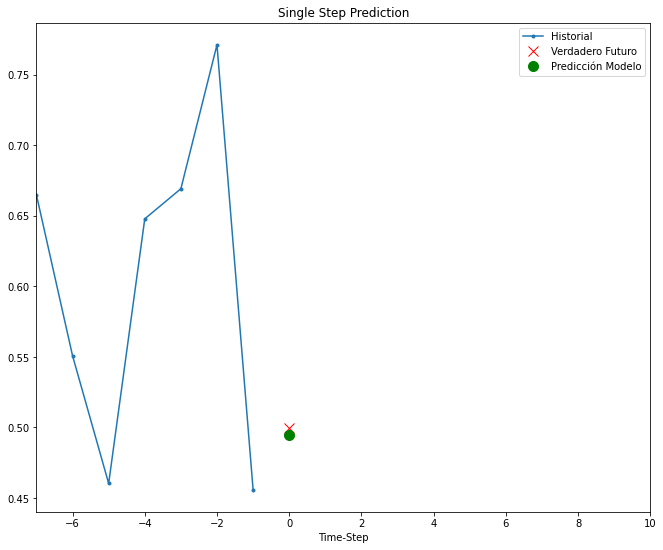

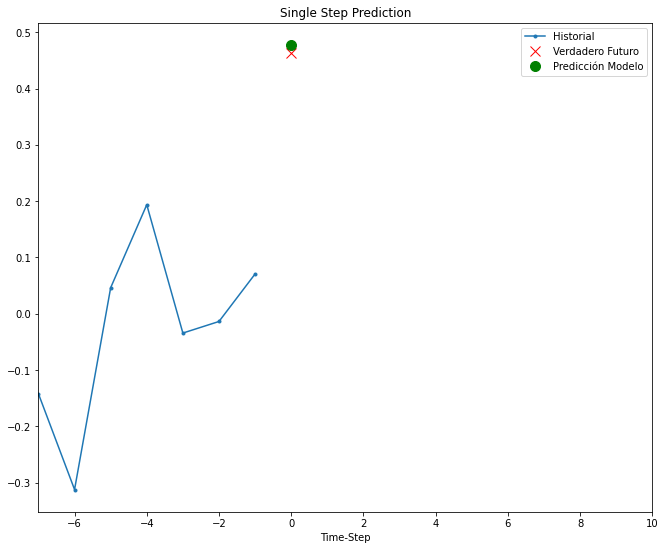

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 250)            271000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 150)            240600    
_________________________________________________________________
flatten (Flatten)            (None, 1050)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               157650    
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 669,401
Trainable params: 669,401
Non-trainable params: 0
__________________________________________________

In [ ]:
#Limpiamos la sesión anterior
tf.keras.backend.clear_session()

#Configuramos y creamos nuestro modelo
multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

#Creamos el archivo de checkpoints
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
#Optimizador de Adam
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

#Compilamos nuestro modelo
multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

#Entrenamos nuestro modelo
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])
#Representamos perdidas y RMSE
plot_model_rmse_and_loss(history)

#Vamos al archivo de los checkpoints para "re-poner"
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

#Predicción e Inversión
forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_stacked_lstm_forecast))
print('RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante de LSTM apilado: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))

print('Vamos a hacer predicciones para 5 conjuntos de valores del conjunto de validación:')

for x, y in validation.take(5):
    show_prediction(
        [x[0][:, 1].numpy(), y[0].numpy(), multivariate_stacked_lstm.predict(x)[0]],
        0,
        "Single Step Prediction",
    )


#Resumen del modelo 
multivariate_stacked_lstm.summary()



Modelo Arima
ARIMA(1,1,1)

Δyt = a1Δyt-1 + ϵt + b1ϵt-1 where Δyt = yt - yt-1

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                35062
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -94647.139
Method:                       css-mle   S.D. of innovations              3.598
Date:                Tue, 08 Jun 2021   AIC                         189300.278
Time:                        11:42:25   BIC                         189325.673
Sample:                             1   HQIC                        189308.366
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.043e-06      0.016     -0.000      1.000      -0.032       0.032
ar.L1.D.y     -0.1930      0.005    -36.828      0.000      -0.203      -0.183
                                    Roots           

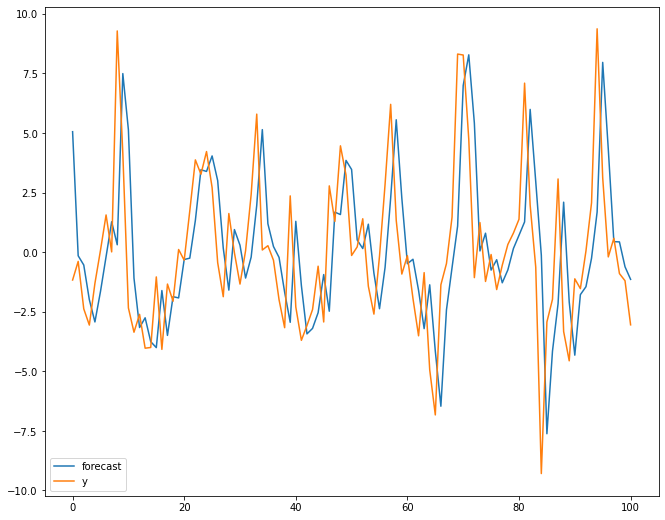

RMSE del precio de la electricidad, pronóstico multivariante de Sarima: 3.5669948998768395.


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

#Creamos nuestro modelo ARIMA y lo entrenamos
model = ARIMA(df_final['price actual'].diff().iloc[1:].values, order=(1,1,0))
result = model.fit()
print(result.summary())

#Pintamos parametros
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

#Criterio de información 
print("Criterio de información {}". format(result.aic))


plt.rcParams['figure.figsize'] = 11, 9
result.plot_predict(start=17000, end=17100)
plt.show()


#Calcuclamos el error
rmse = sqrt(mean_squared_error(df_final['price actual'].diff().iloc[17000:17101], result.predict(start=17000,end=17100)))
print("RMSE del precio de la electricidad, pronóstico multivariante de Sarima: {}.".format(rmse))

Modelo SARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                35063
Model:               SARIMAX(4, 0, 4)   Log Likelihood              -86806.418
Date:                Tue, 08 Jun 2021   AIC                         173632.836
Time:                        11:42:47   BIC                         173717.485
Sample:                             0   HQIC                        173659.797
                              - 35063                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.011      0.015      0.988      -0.022       0.022
ar.L1          0.6282      0.018     35.532      0.000       0.594       0.663
ar.L2          0.7737      0.014     54.699      0.0

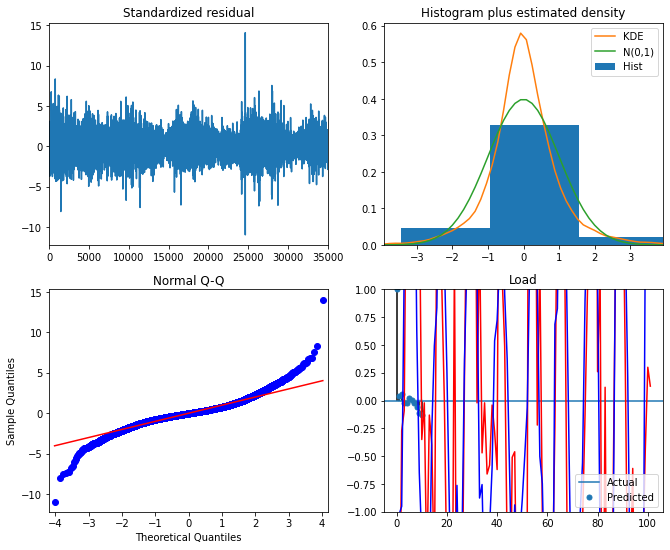

CNN-LSTM

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
846/846 [==============================] - 5s 4ms/step - loss: 0.0071 - root_mean_squared_error: 0.0791 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 2/120
846/846 [==============================] - 3s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0348 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 3/120
846/846 [==============================] - 3s 4ms/step - loss: 9.0176e-04 - root_mean_squared_error: 0.0300 - val_loss: 8.8121e-04 - val_root_mean_squared_error: 0.0297
Epoch 4/120
846/846 [==============================] - 3s 4ms/step - loss: 6.8389e-04 - root_mean_squared_error: 0.0262 - val_loss: 8.7082e-04 - val_root_mean_squared_error: 0.0295
Epoch 5/120
846/846 [==============================] - 3s 4ms/step - loss: 6.2132e-04 - root_mean_squared_error: 0.0249 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 6/120
846/846 [==============================] - 3s 4ms/step - loss: 5.8078e-04 - root_mean_squared_error: 0.

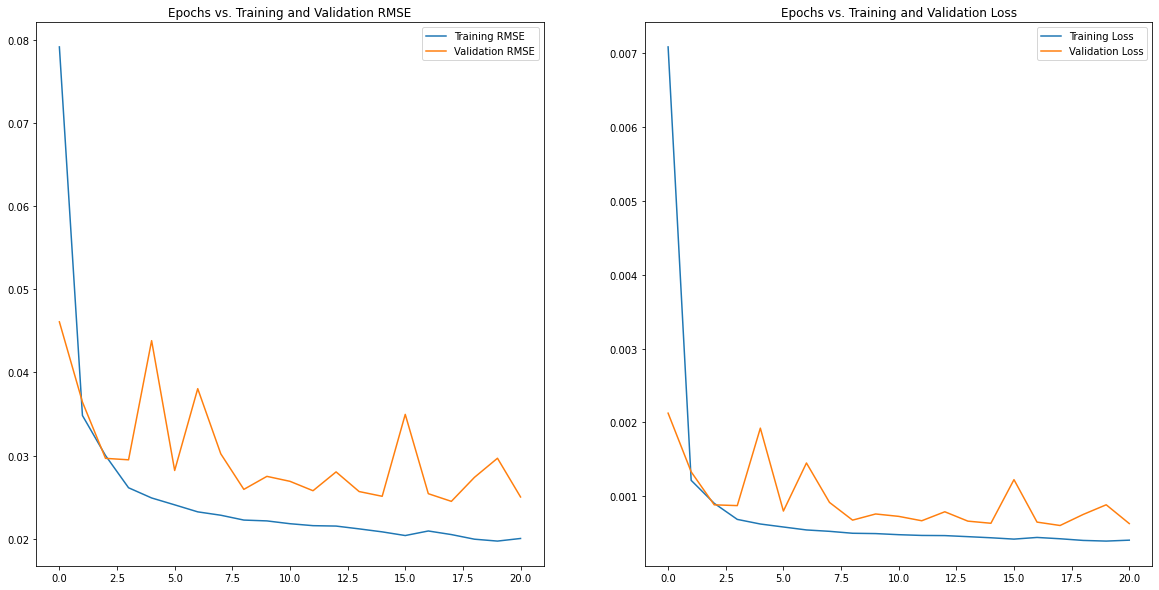

RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante de CNN-LSTM: 2.603
Vamos a hacer predicciones para 5 conjuntos de valores del conjunto de validación:


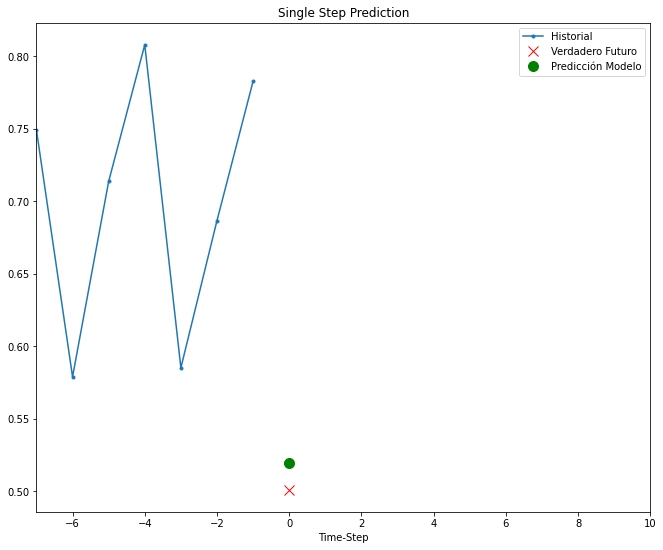

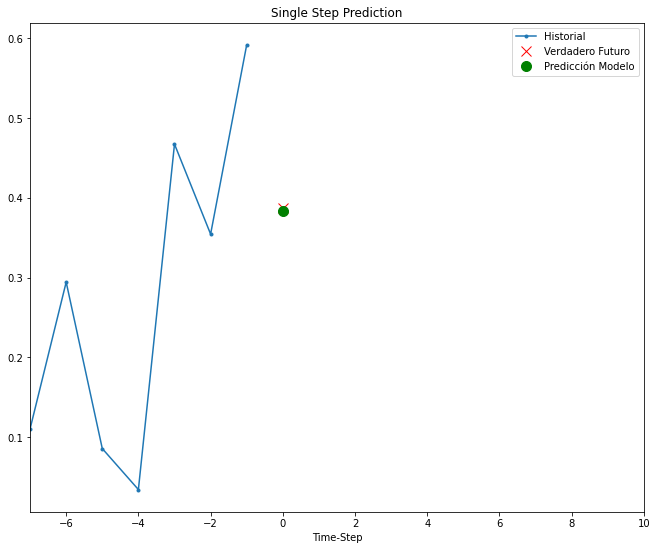

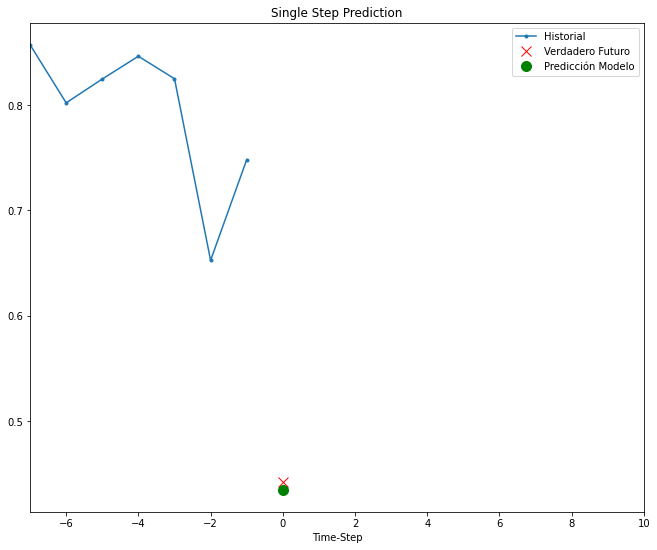

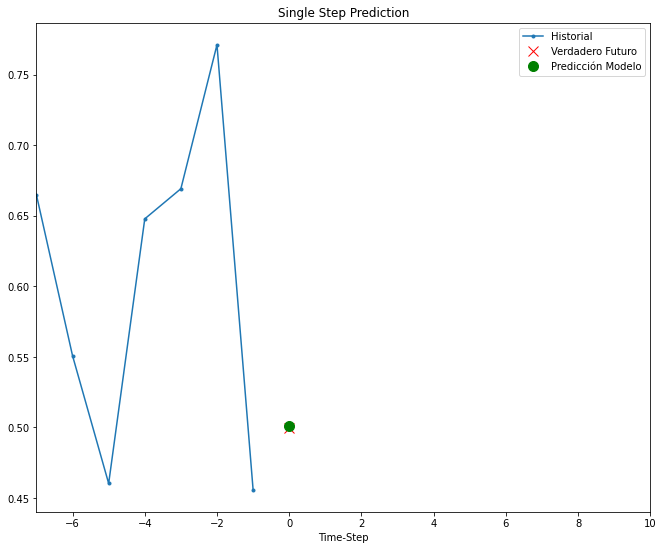

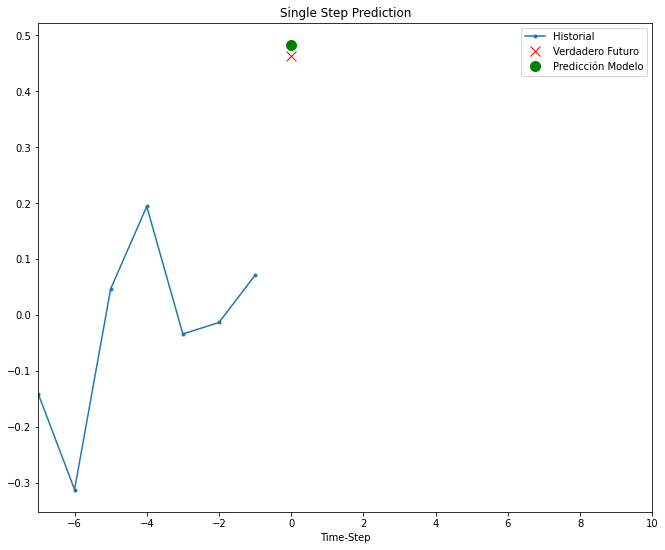

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7, 200)            8200      
_________________________________________________________________
lstm (LSTM)                  (None, 7, 200)            320800    
_________________________________________________________________
flatten (Flatten)            (None, 1400)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               210150    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 539,301
Trainable params: 539,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Limpiamos sesión anterior
tf.keras.backend.clear_session()

#Configuramos nuestro modelo y sus capas 
#100 100 50
multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=200, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(200, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dense(1)
])

#Configuramos el archivo donde se guardan los CheckPoints
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)

#Utilizamos el optimizador de Adam
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

#Compilamos nuestro modelo, ajuste de parametros importantes
multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

#Entrenamos nuestro modelo
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

#Gráfica de RMSE y pérdidas
plot_model_rmse_and_loss(history)

#Reogemos del checkpoint
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

#Predecimos
forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

#Valor del MSE
rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, 
                                             multivariate_cnn_lstm_forecast))
print('RMSE del precio de la electricidad con una hora de anticipación, pronóstico multivariante de CNN-LSTM: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

print('Vamos a hacer predicciones para 5 conjuntos de valores del conjunto de validación:')

for x, y in validation.take(5):
    show_prediction(
        [x[0][:, 1].numpy(), y[0].numpy(), multivariate_cnn_lstm.predict(x)[0]],
        0,
        "Single Step Prediction",
    )

#Resumen del modelo
multivariate_cnn_lstm.summary()

# Sección de pruebas 

Conjunto de modelos que estoy probando y haciendo pruebas aún:

Random Forest (RF)


In [ ]:
tf.keras.backend.clear_session()

random_forest = tf.keras.RandomForestModel()
random_forest.fit(train)

random_forest.summary()


random_forest.evaluate(test_ds)



# Representamos graficas con los resultados
#pyplot.plot(y, label='Expected')
#pyplot.plot(yhat, label='Predicted')
#pyplot.legend()
#pyplot.show()

AttributeError: ignored

CNN

In [ ]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])
plot_model_rmse_and_loss(history)

multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

Time Distributed MLP

In [ ]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])
plot_model_rmse_and_loss(history)

multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

Encoder-Decoder

In [ ]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)
history = encoder_decoder.fit(train, epochs=50,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])
plot_model_rmse_and_loss(history)

encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, 
                                               encoder_decoder_forecast))
print('RMSE of hour-ahead electricity price Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))